In [54]:
%matplotlib inline

from shared_content import *

In [55]:
# Do you want to write figures to png files? Careful, it will overwrite!
write_figures = True
figdir = 'Figures/'

In [56]:
filedir = 'anafiles/'
anatype = 'MCBNBRecoTrack' 

seglen = 10
myfile = 'MCSBiasStudy_%s_anaout_%dcmseg_2res_bothscatters_nonrelfix.root' %( anatype, seglen )
print myfile

MCSBiasStudy_MCBNBRecoTrack_anaout_10cmseg_2res_bothscatters_nonrelfix.root


In [57]:
df, segdf = get_dfs(filedir + myfile)
print len(segdf)
print df.columns.values

267617
['full_length' 'full_integrated_length' 'full_range_energy'
 'full_range_momentum' 'full_integrated_range_energy'
 'full_integrated_range_momentum' 'full_MCS_energy' 'full_MCS_momentum'
 'true_E' 'theta' 'run' 'subrun' 'eventid' 'full_MCS_momentum_inverse'
 'full_range_momentum_inverse' 'MCT_PDG' 'MCT_origin']


In [58]:
#reco-true/true
def fractional_bias_resolution_plot(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                    yvar = 'full_MCS_momentum', slicevar = 'full_range_momentum',
                    plot_bin_distributions = False, extraquery = None, slicetitlebase = None,
                    slicebins = np.linspace(-0.8,.8,20),
                    biasplotname = None, resplotname = None, biasmainfig_ylims = None,
                    resmainfig_ylims = None,
                    usegausfit = False,
                    biasylabel = None,
                    biaslegendlabel = None,
                    resylabel = None,
                    reslegendlabel = None):

    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    myreses, mystds, myerrs_bias, myerrs_res = [], [], [], []

    for x in xrange(len(binning)-1):
        
        binmin = binning[x]
        binmax = binning[x+1]
        #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
        myquery = '%s > %f and %s < %f'%(slicevar,binmin,slicevar,binmax)
        if anatype == 'DataBNBSelectedRecoTrack': 
            myquery += ' and not maybe_bad'
        if extraquery is not None:
            myquery += ' and %s' % extraquery
            
        mydf = df.query(myquery)
        true = mydf[xvar].values
        reco = mydf[yvar].values
        mymean = ((reco-true)/true).mean()
        mystd = ((reco-true)/true).std()
        
        if plot_bin_distributions:
            plt.figure(figsize=(5,3))
            datahist = plt.hist((reco-true)/true,color='r',alpha=0.5,label='%d Entries'%len((reco-true)/true),\
                     bins=slicebins)
            titlestring = '$\\frac{%s - %s}{%s}$ for $%s$ in %0.2f $\\rightarrow$ %0.2f GeV'% \
            (latextitles[yvar],latextitles[xvar],latextitles[xvar],latextitles[slicevar],binmin,binmax)
            t =plt.title(titlestring,fontsize=16)
            #move the title up a bit
            t.set_y(1.04) 
            plt.grid(False)
            
            # Plot gaussian on each bin distribution
            if usegausfit:
                 
                slicebinvals = datahist[0]
                slicebincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
    
                # Fit a normal distribution
                gmod = Model(gaussian)
                #initial random guesses of 1, 1, 2
                result = gmod.fit(slicebinvals, x=slicebincenters, amp=1, cen=1, wid=2)

                thisx = np.linspace(np.min(slicebins),np.max(slicebins),100)
                thisy = gaussian(thisx, result.params['amp'], result.params['cen'], result.params['wid'])
                plt.plot(thisx, thisy, 'g-',\
                     label='Gaus Fit',\
                     linewidth=2)
                addtext = 'Fit: \n$\sigma$ = %0.2f, \n$\mu$ = %0.2f'%\
                (np.abs(result.params['wid']),result.params['cen'])
                plt.text(plt.xlim()[1]*0.35, plt.ylim()[1]*0.1, addtext, fontsize=14)
                
                # If use gaus fit, use the result of that instead of straight mean and RMS
                mymean = result.params['cen']
                #Somehow when there are like 2 data points you get a negative width?!
                mystd  = np.abs(result.params['wid'])
                # If the fit doesn't converge, 'wid' will be the initial guess of 2.0... don't use these points then
                # (this only happens when no entries in the sliced histogram)
                if int(result.params['wid']) == 2:
                    print "WARNING: FIT DIDN'T CONVERGE!"
                    mymean = ((reco-true)/true).mean()
                    mystd = ((reco-true)/true).std()
                    
             
                
                
            plt.xlabel('$\\frac{%s - %s}{%s}$'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=16)
            plt.ylabel('Counts',fontsize=16)
            plt.xlim((np.min(slicebins),np.max(slicebins)))
            plt.legend(loc=1)
            if write_figures and slicetitlebase is not None:
                fullfigname = figdir + slicetitlebase + '_slice_%0.2f_%0.2f.png'%(binmin,binmax)
                print '\n\n WRITING A FIGURE!! %s\n\n'%fullfigname
                plt.tight_layout()
                plt.savefig(fullfigname)
        
        
        myerr_bias = mystd / np.sqrt( float(len(true)) )
        myerr_res = mystd / np.sqrt( float(2*len(true)) )
        myreses.append( mymean )
        mystds.append( mystd )
        myerrs_bias.append( myerr_bias )
        myerrs_res.append( myerr_res )
        
        
    #BIAS PLOT    
    plt.figure(figsize=(10,6))
    mylabel = 'Mean of Gaussian Fit, Errors = $\sigma$/sqrt(N)'
    if biaslegendlabel is not None:
        mylabel = biaslegendlabel
    plt.errorbar(bincenters[:-1],myreses,yerr=myerrs_bias,xerr=binwidth/2,fmt='ro',label=mylabel)
    if biasylabel is None:
        plt.ylabel('GausMean($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    else:
        plt.ylabel(biasylabel,fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=15)
    plt.grid(True)
    plt.legend(loc='best')
    t = plt.title('Fractional Bias: %s'%titles[anatype],fontsize=16)
    t.set_y(1.04)
    if biasmainfig_ylims is not None:
        blah = plt.ylim(biasmainfig_ylims)
    if write_figures and biasplotname is not None:
        print " \n\n Writing the main bias figure!! %s\n\n" % (figdir+biasplotname)
        plt.tight_layout()
        plt.savefig(figdir + biasplotname)
        
    #RESOLUTION PLOT
    plt.figure(figsize=(10,6))
    mylabel = 'Width of Gaussian Fit, Errors = $\sigma$/sqrt(2N)'
    if reslegendlabel is not None:
        mylabel = reslegendlabel
    plt.errorbar(bincenters[:-1],mystds,yerr=myerrs_res,xerr=binwidth/2,fmt='bo',label=mylabel)
    if resylabel is None:
        plt.ylabel('GausWidth($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    else:
        plt.ylabel(resylabel,fontsize=25)
   
    plt.xlabel('%s'%titles[slicevar],fontsize=15)
    plt.grid(True)
    t = plt.title('Momentum Resolution: %s' % titles[anatype],fontsize=16)
    plt.legend(loc='best')
    #move the title up a bit
    t.set_y(1.05) 
                    
    if resmainfig_ylims is not None:
        blah = plt.ylim(resmainfig_ylims)
    if write_figures and resplotname is not None:
        print " \n\n Writing the main resolution figure!! %s \n\n" % (figdir+resplotname)
        plt.tight_layout()
        plt.savefig(figdir + resplotname)



 WRITING A FIGURE!! Figures/MCS_range_resolution_MCBNBRecoTrack_GAUSVALIDATION_inverse_gaus_slice_0.35_0.53.png




 WRITING A FIGURE!! Figures/MCS_range_resolution_MCBNBRecoTrack_GAUSVALIDATION_inverse_gaus_slice_0.53_0.72.png




 WRITING A FIGURE!! Figures/MCS_range_resolution_MCBNBRecoTrack_GAUSVALIDATION_inverse_gaus_slice_0.72_0.90.png




 WRITING A FIGURE!! Figures/MCS_range_resolution_MCBNBRecoTrack_GAUSVALIDATION_inverse_gaus_slice_0.90_1.08.png




 WRITING A FIGURE!! Figures/MCS_range_resolution_MCBNBRecoTrack_GAUSVALIDATION_inverse_gaus_slice_1.08_1.27.png




 WRITING A FIGURE!! Figures/MCS_range_resolution_MCBNBRecoTrack_GAUSVALIDATION_inverse_gaus_slice_1.27_1.45.png




 WRITING A FIGURE!! Figures/MCS_range_resolution_MCBNBRecoTrack_GAUSVALIDATION_inverse_gaus_slice_1.45_1.63.png




 WRITING A FIGURE!! Figures/MCS_range_resolution_MCBNBRecoTrack_GAUSVALIDATION_inverse_gaus_slice_1.63_1.82.png




 WRITING A FIGURE!! Figures/MCS_range_resolution_MCBNBRecoTrack_GAUSVA

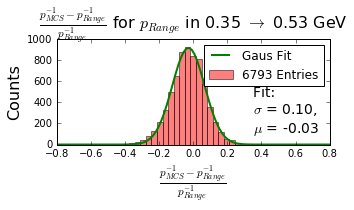

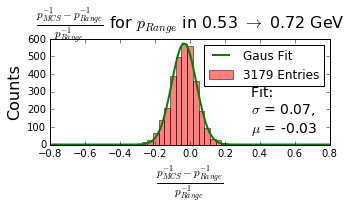

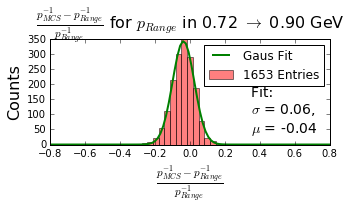

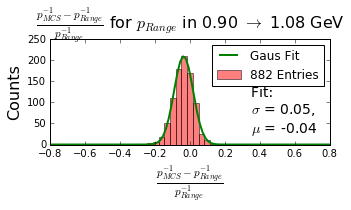

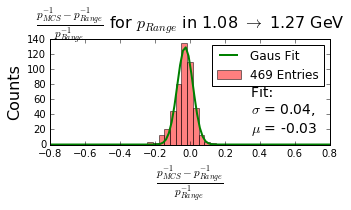

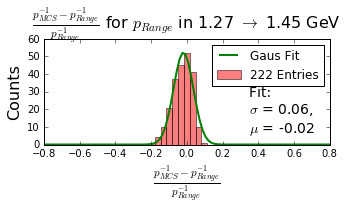

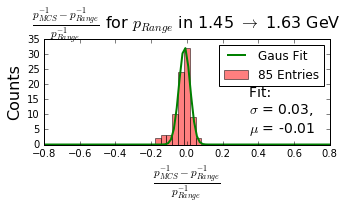

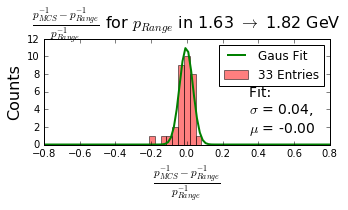

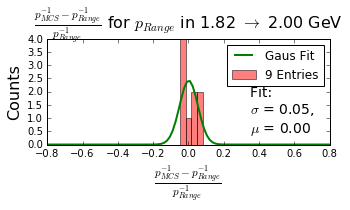

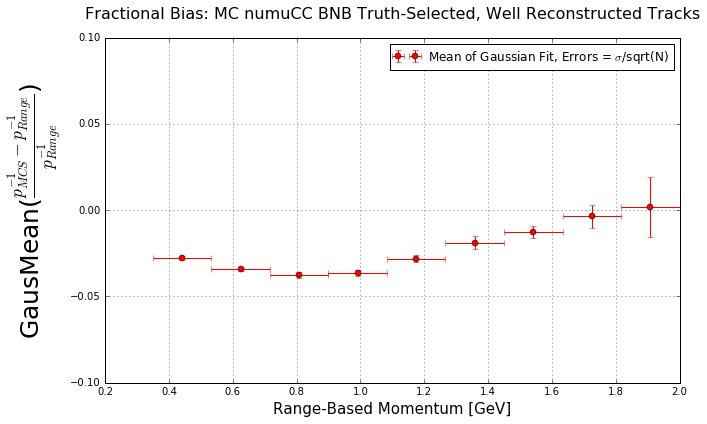

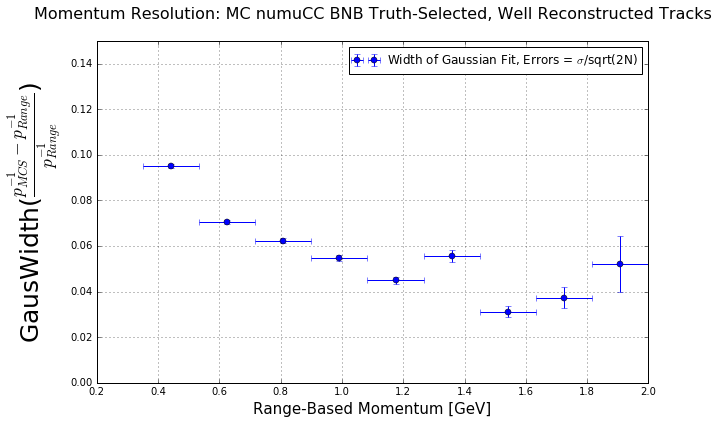

In [59]:
myextraquery = None

# Here we use inverse momentum
fractional_bias_resolution_plot(xvar='full_range_momentum_inverse',yvar='full_MCS_momentum_inverse',
                     xbins=np.linspace(0.35,2,10),
                       plot_bin_distributions = True,
                       slicevar = 'full_range_momentum',
                       extraquery = myextraquery,
                       slicetitlebase = 'MCS_range_resolution_%s_GAUSVALIDATION_inverse_gaus'%anatype,
                       slicebins = np.linspace(-0.8,0.8,50),
                       biasplotname = 'MCS_range_bias_%s_GAUSVALIDATION_inverse_gaus.png'%anatype,
                       resplotname = 'MCS_range_resolution_%s_GAUSVALIDATION_inverse_gaus.png'%anatype,
                       biasmainfig_ylims = (-.10,.10),
                       resmainfig_ylims = (0,.15),
                        usegausfit = True)



 WRITING A FIGURE!! Figures/MCS_range_resolution_MCBNBRecoTrack_GAUSVALIDATION_normal_gaus_slice_0.35_0.53.png




 WRITING A FIGURE!! Figures/MCS_range_resolution_MCBNBRecoTrack_GAUSVALIDATION_normal_gaus_slice_0.53_0.72.png




 WRITING A FIGURE!! Figures/MCS_range_resolution_MCBNBRecoTrack_GAUSVALIDATION_normal_gaus_slice_0.72_0.90.png




 WRITING A FIGURE!! Figures/MCS_range_resolution_MCBNBRecoTrack_GAUSVALIDATION_normal_gaus_slice_0.90_1.08.png




 WRITING A FIGURE!! Figures/MCS_range_resolution_MCBNBRecoTrack_GAUSVALIDATION_normal_gaus_slice_1.08_1.27.png




 WRITING A FIGURE!! Figures/MCS_range_resolution_MCBNBRecoTrack_GAUSVALIDATION_normal_gaus_slice_1.27_1.45.png




 WRITING A FIGURE!! Figures/MCS_range_resolution_MCBNBRecoTrack_GAUSVALIDATION_normal_gaus_slice_1.45_1.63.png




 WRITING A FIGURE!! Figures/MCS_range_resolution_MCBNBRecoTrack_GAUSVALIDATION_normal_gaus_slice_1.63_1.82.png




 WRITING A FIGURE!! Figures/MCS_range_resolution_MCBNBRecoTrack_GAUSVALIDATION

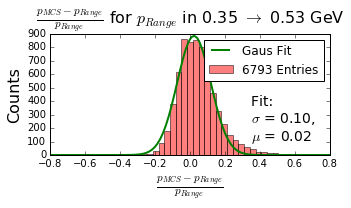

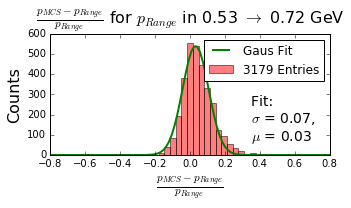

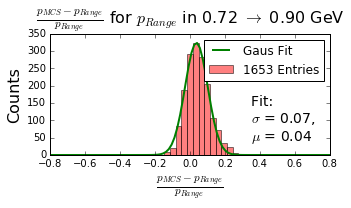

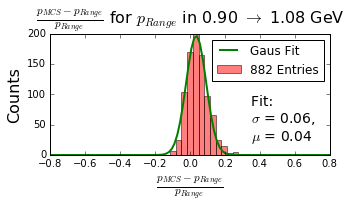

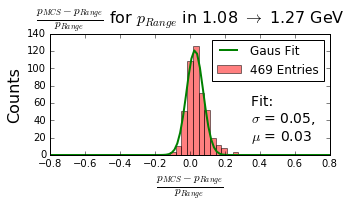

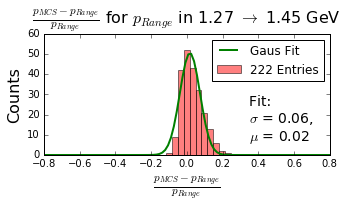

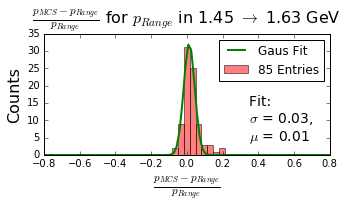

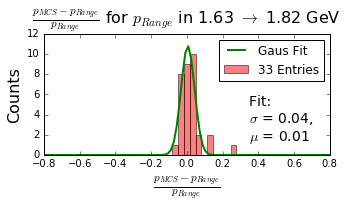

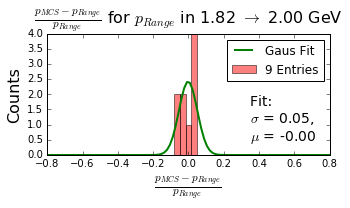

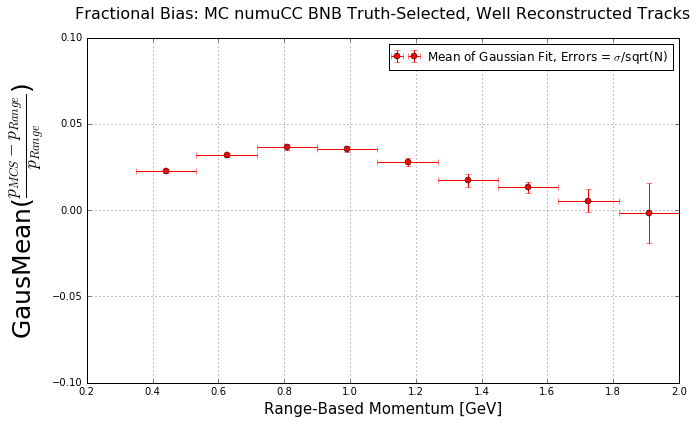

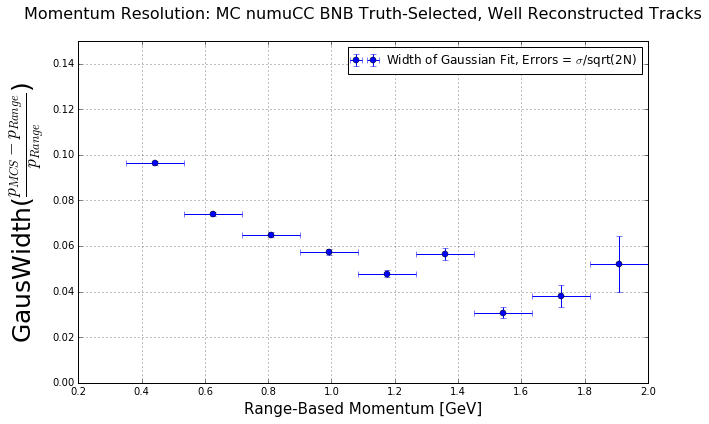

In [60]:
myextraquery = None

# Here we use normal momentum
fractional_bias_resolution_plot(xvar='full_range_momentum',yvar='full_MCS_momentum',
                     xbins=np.linspace(0.35,2,10),
                       plot_bin_distributions = True,
                       slicevar = 'full_range_momentum',
                       extraquery = myextraquery,
                       slicetitlebase = 'MCS_range_resolution_%s_GAUSVALIDATION_normal_gaus'%anatype,
                       slicebins = np.linspace(-0.8,0.8,50),
                       biasplotname = 'MCS_range_bias_%s_GAUSVALIDATION_normal_gaus.png'%anatype,
                       resplotname = 'MCS_range_resolution_%s_GAUSVALIDATION_normal_gaus.png'%anatype,
                       biasmainfig_ylims = (-.10,.10),
                       resmainfig_ylims = (0,.15),
                        usegausfit = True)

 

 Writing the main bias figure!! Figures/MCS_range_bias_MCBNBRecoTrack_GAUSVALIDATION_normal_std.png


 

 Writing the main resolution figure!! Figures/MCS_range_resolution_MCBNBRecoTrack_GAUSVALIDATION_normal_std.png 




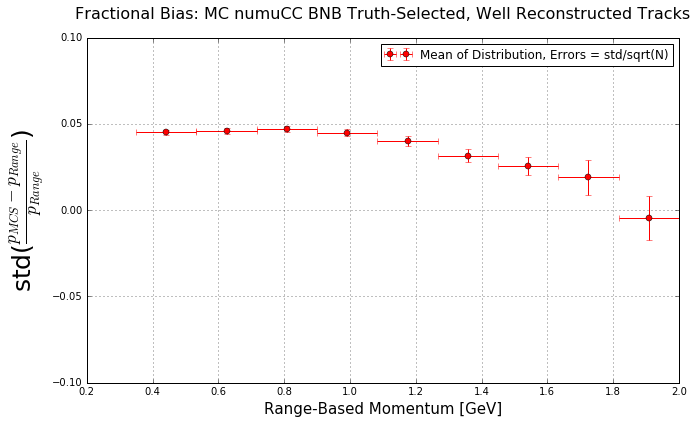

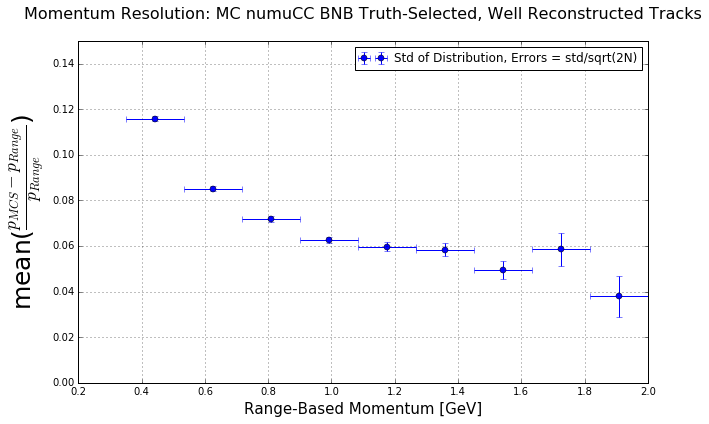

In [61]:
myextraquery = None

xvar = 'full_range_momentum'
yvar = 'full_MCS_momentum'
biasylabel = 'std($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar])
resylabel = 'mean($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar])
biaslegendlabel = 'Mean of Distribution, Errors = std/sqrt(N)'
reslegendlabel = 'Std of Distribution, Errors = std/sqrt(2N)'
# Here we use normal momentum with no gaussian fits, just plain STD
fractional_bias_resolution_plot(xvar=xvar,yvar=yvar,
                     xbins=np.linspace(0.35,2,10),
                       plot_bin_distributions = False,
                       slicevar = 'full_range_momentum',
                       extraquery = myextraquery,
                       slicetitlebase = 'MCS_range_resolution_%s_GAUSVALIDATION_normal_std'%anatype,
                       slicebins = np.linspace(-0.8,0.8,50),
                       biasplotname = 'MCS_range_bias_%s_GAUSVALIDATION_normal_std.png'%anatype,
                       resplotname = 'MCS_range_resolution_%s_GAUSVALIDATION_normal_std.png'%anatype,
                       biasmainfig_ylims = (-.10,.10),
                       resmainfig_ylims = (0,.15),
                        usegausfit = False,
                        biasylabel = biasylabel,
                               resylabel = resylabel,
                               biaslegendlabel = biaslegendlabel,
                               reslegendlabel = reslegendlabel)

 

 Writing the main bias figure!! Figures/MCS_range_bias_MCBNBRecoTrack_GAUSVALIDATION_inverse_std.png


 

 Writing the main resolution figure!! Figures/MCS_range_resolution_MCBNBRecoTrack_GAUSVALIDATION_inverse_std.png 




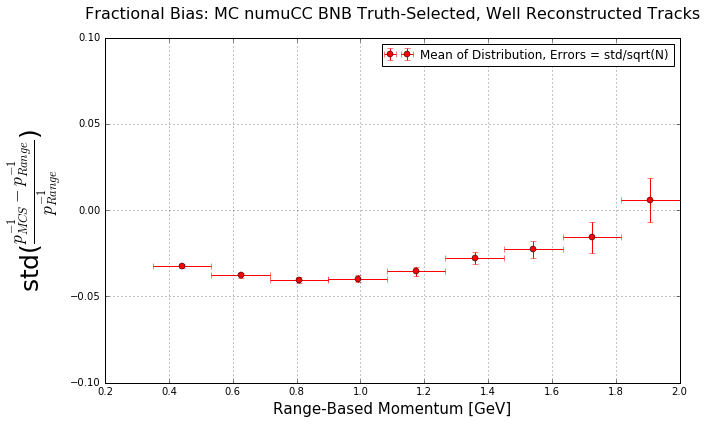

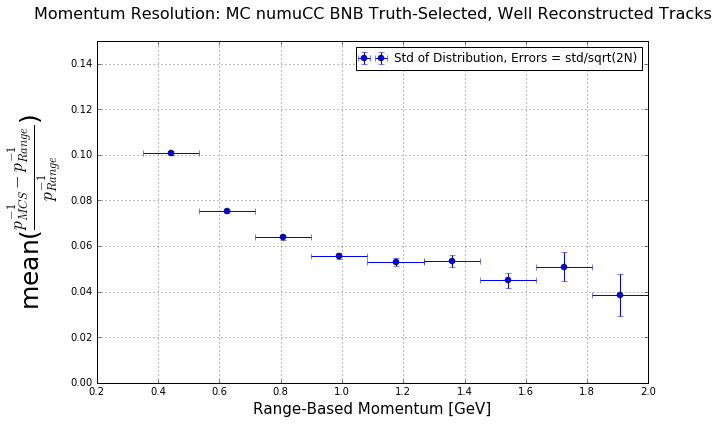

In [62]:
myextraquery = None

xvar = 'full_range_momentum_inverse'
yvar = 'full_MCS_momentum_inverse'
biasylabel = 'std($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar])
resylabel = 'mean($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar])
biaslegendlabel = 'Mean of Distribution, Errors = std/sqrt(N)'
reslegendlabel = 'Std of Distribution, Errors = std/sqrt(2N)'
# Here we use normal momentum with no gaussian fits, just plain STD
fractional_bias_resolution_plot(xvar=xvar,yvar=yvar,
                     xbins=np.linspace(0.35,2,10),
                       plot_bin_distributions = False,
                       slicevar = 'full_range_momentum',
                       extraquery = myextraquery,
                       slicetitlebase = 'MCS_range_resolution_%s_GAUSVALIDATION_inverse_std'%anatype,
                       slicebins = np.linspace(-0.8,0.8,50),
                       biasplotname = 'MCS_range_bias_%s_GAUSVALIDATION_inverse_std.png'%anatype,
                       resplotname = 'MCS_range_resolution_%s_GAUSVALIDATION_inverse_std.png'%anatype,
                       biasmainfig_ylims = (-.10,.10),
                       resmainfig_ylims = (0,.15),
                        usegausfit = False,
                        biasylabel = biasylabel,
                               resylabel = resylabel,
                               biaslegendlabel = biaslegendlabel,
                               reslegendlabel = reslegendlabel)